In [1]:
import numpy as np
import pickle
from glob import glob
import corner
from mcmc import Ebola

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 22})

In [3]:
par = ('beta', 'k', 'tau', 'sigma', 'gamma', 'f', 'offset',
       'scatter_cases', 'scatter_cases_outlier', 'prob_cases_outlier',
       'scatter_deaths', 'scatter_deaths_outlier', 'prob_deaths_outlier')
ndim = len(par)  # number of parameters in the model
nburn = 300
N = 1000000

In [4]:
e = Ebola(N, 'guinea')

In [5]:
ratio = e.delta_deaths / e.delta_cases
ratio = ratio[e.delta_cases > 0]

/usr/local/anaconda/envs/py3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


(-0.47187499999995208, 3)

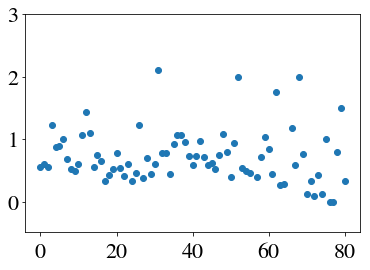

In [6]:
plt.plot(ratio, 'o')
plt.ylim(top=3)

In [7]:
filename = sorted(glob('chain-2019-05-23T15*.pickle'))[-1]
print(filename)

chain-2019-05-23T15:15.pickle


In [8]:
with open(filename, 'rb') as f:
    chain, lnprob = pickle.load(f)
print(chain.shape)
print(lnprob.shape)

(500, 601, 13)
(500, 601)


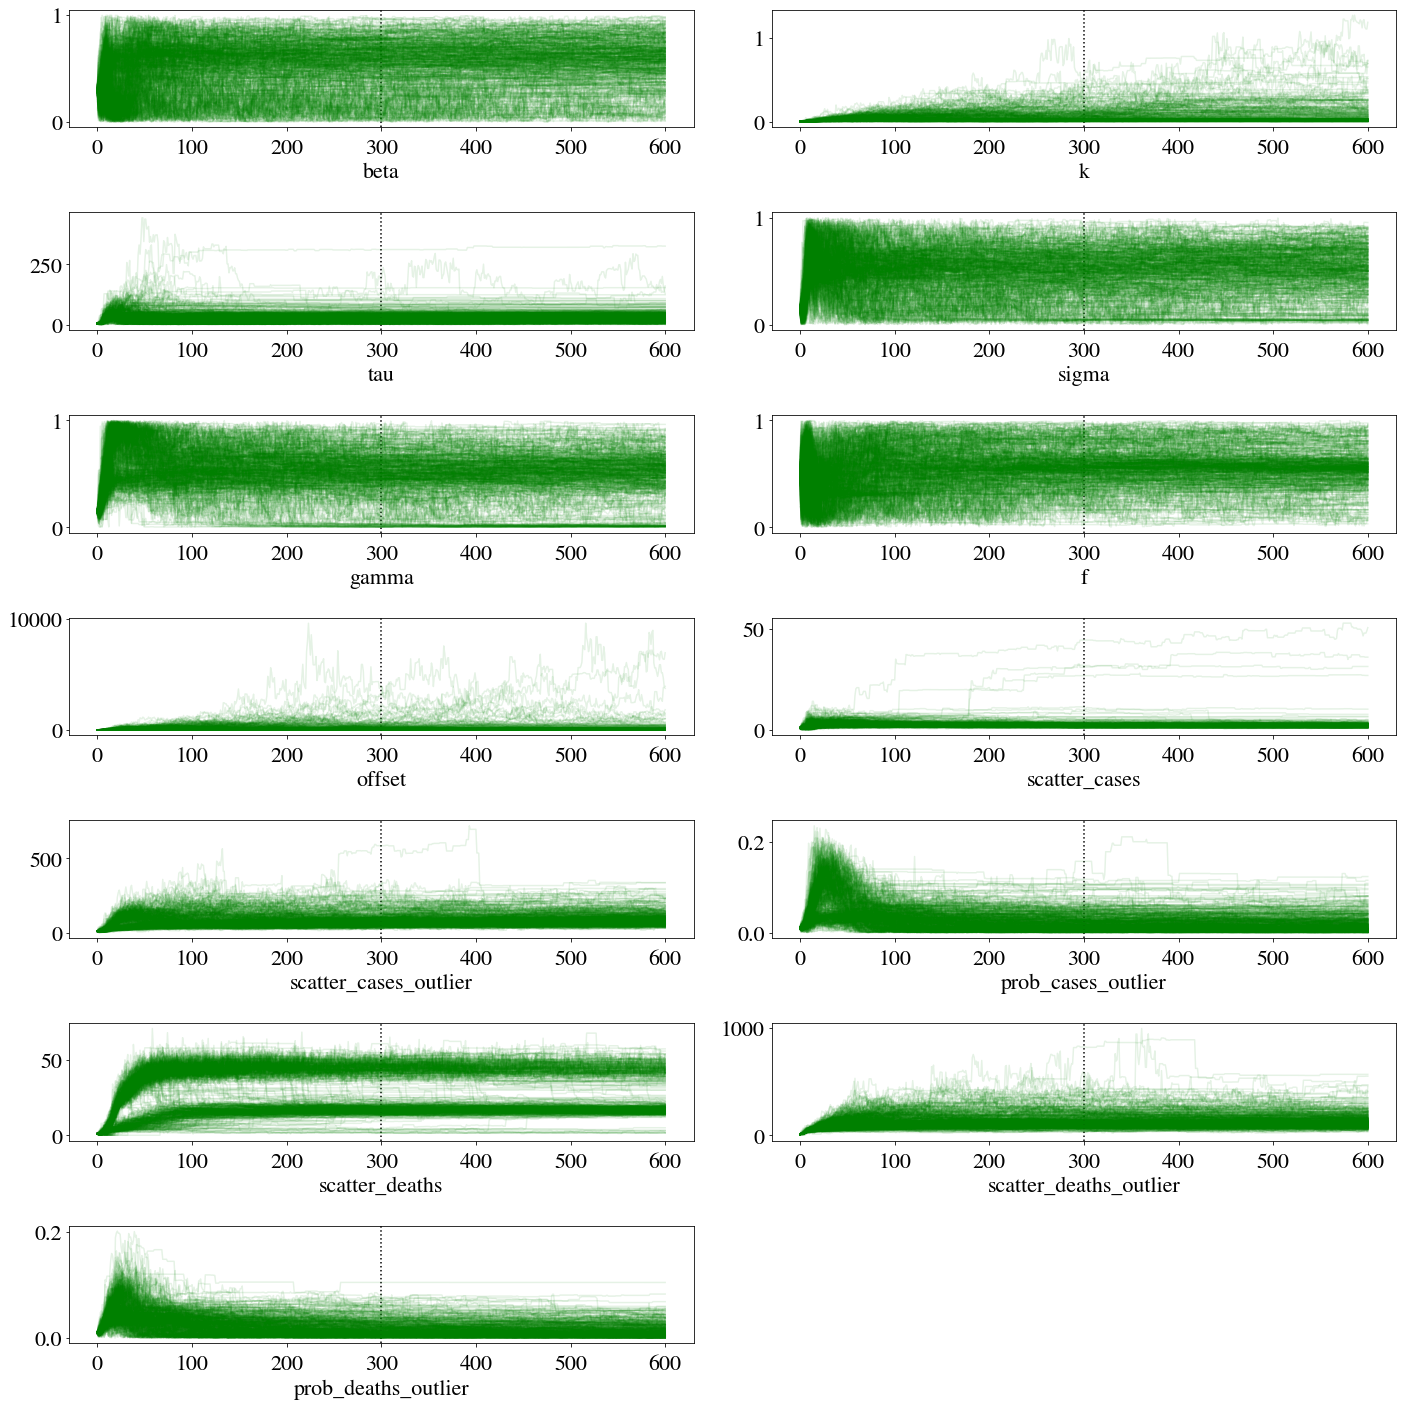

In [9]:
# plot the chains to visually assess convergence
plt.figure(figsize=[20,20])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    for w in range(chain.shape[0]):
            #plt.plot(numpy.arange(chain.shape[2]), chain[2,w,:,i], 'r-', alpha=0.1)
            plt.plot(numpy.arange(chain.shape[1]), chain[w,:,i], 'g-', alpha=0.1)
    plt.xlabel(p)
    aymin, aymax = plt.ylim()
    plt.vlines(nburn, aymin, aymax, linestyle=':')
    plt.ylim(aymin, aymax)
    plt.tight_layout()

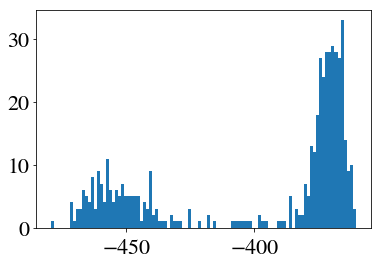

In [10]:
plt.hist(lnprob[:, -100], bins=100);

In [11]:
chain = chain[lnprob[:, -200:].mean(axis=1) > -380]
lnprob = lnprob[lnprob[:, -200:].mean(axis=1) > -380]

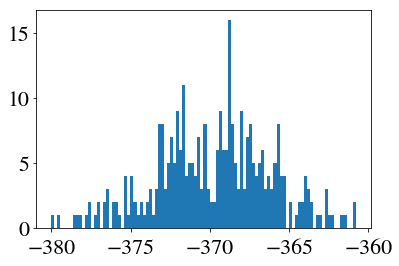

In [12]:
plt.hist(lnprob[:, -100:].mean(axis=1), bins=100);

In [13]:
print(lnprob.shape[0])

314


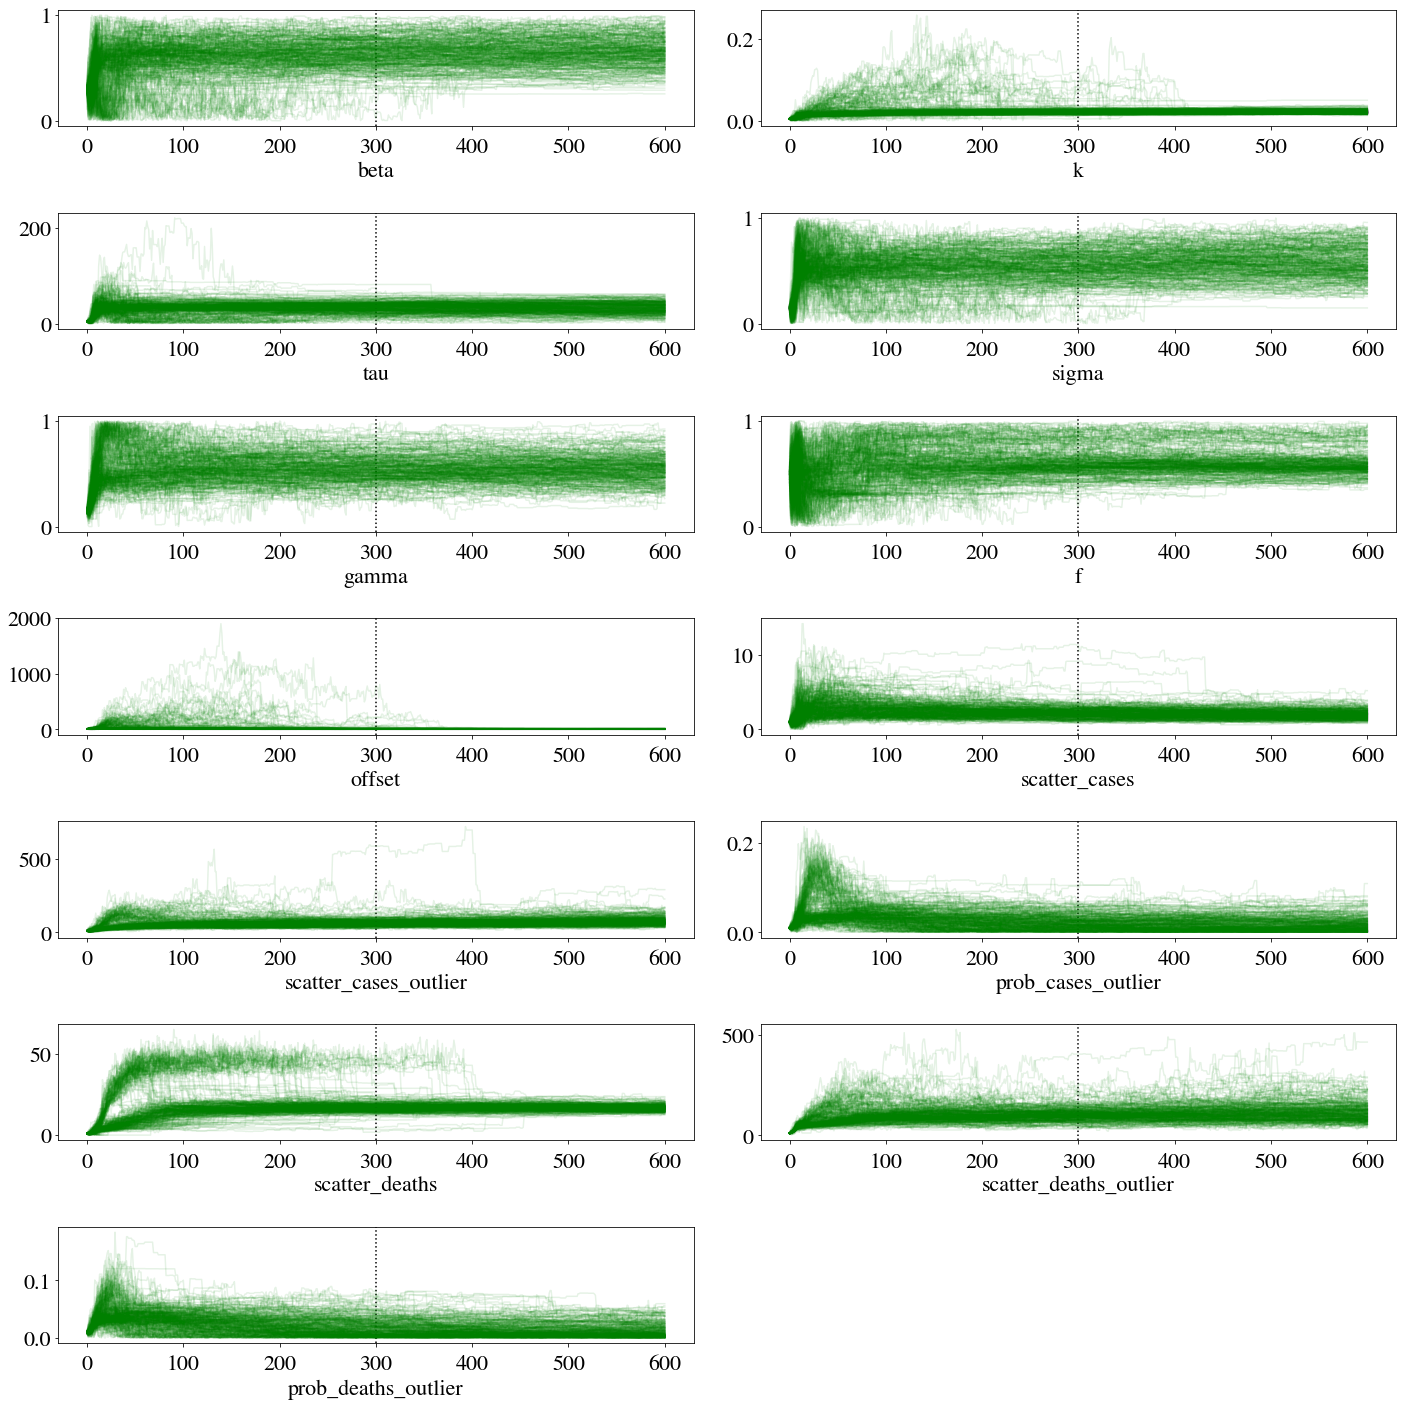

In [14]:
# plot the chains to visually assess convergence
plt.figure(figsize=[20,20])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    for w in range(chain.shape[0]):
            #plt.plot(numpy.arange(chain.shape[2]), chain[2,w,:,i], 'r-', alpha=0.1)
            plt.plot(numpy.arange(chain.shape[1]), chain[w,:,i], 'g-', alpha=0.1)
    plt.xlabel(p)
    aymin, aymax = plt.ylim()
    plt.vlines(nburn, aymin, aymax, linestyle=':')
    plt.ylim(aymin, aymax)
    plt.tight_layout()

In [15]:
# plot the chains to visually assess auto correlation time at equilibrium
#plt.figure(figsize=[20,20])
#for i, p in enumerate(par):
#    plt.subplot((ndim+1)//2, 2, i+1)
#    for w in range(0,nwalkers,10):
#            plt.plot(numpy.arange(100), chain[2,w,nburn:nburn+100,i], 'r-')
#            plt.plot(numpy.arange(100), chain[0,w,nburn:nburn+100,i], 'g-')
#    plt.xlabel(p)
#    aymin = np.min(chain[0,:,nburn:,i])
#    aymax = np.max(chain[0,:,nburn:nburn+100,i])
#    plt.ylim(aymin, aymax)
#    plt.tight_layout()

In [16]:
def get_samples(c, nburn):
    if c.ndim == 4:
        c = c[0]
    c = c[:, nburn:]
    return c.reshape((np.product(c.shape[:-1]), c.shape[-1]))

In [17]:
samples = get_samples(chain, nburn)
samples_lnprob = lnprob[:, nburn:].flatten()

In [18]:
#samples = samples[samples_lnprob > -390]

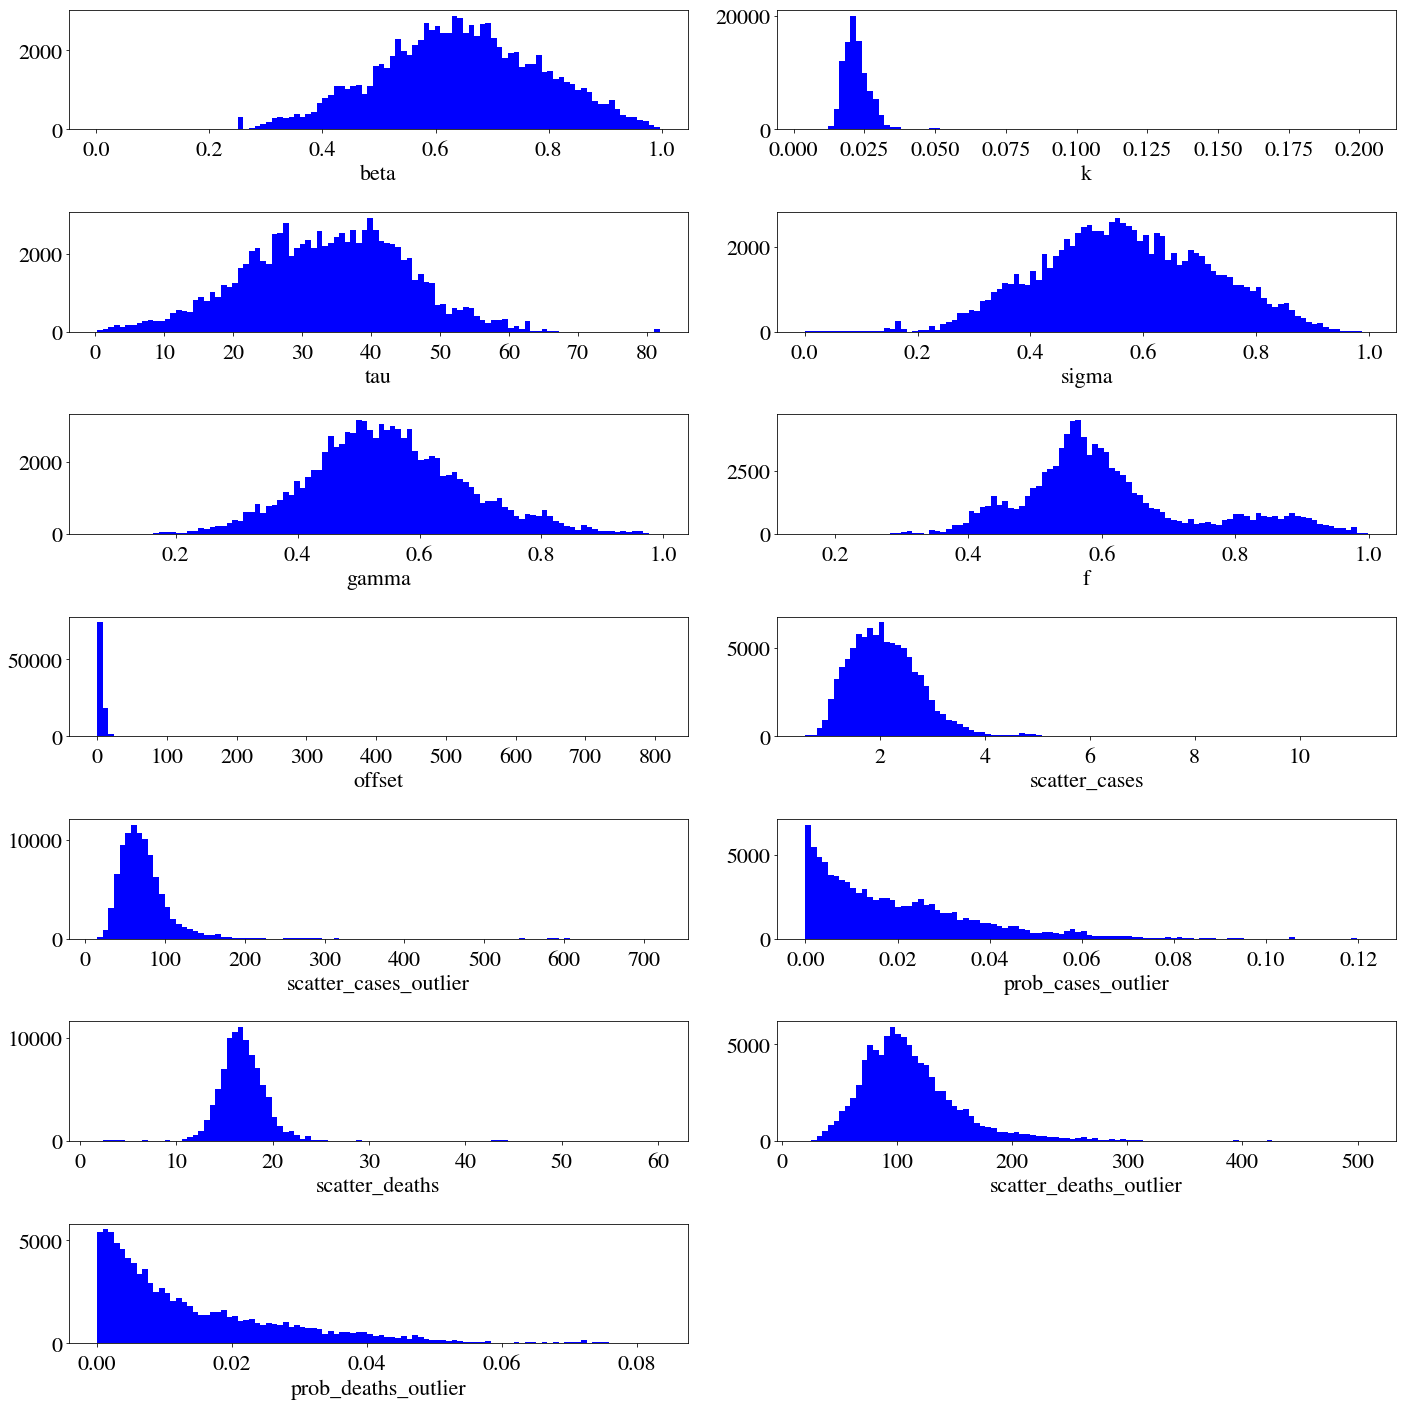

In [19]:
# examine parameter histograms
plt.figure(figsize=[20,20])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    n, b, patches = plt.hist(samples[:,i], bins=100, color='b', histtype='stepfilled', log=False)
    plt.xlabel(p)
    plt.tight_layout()

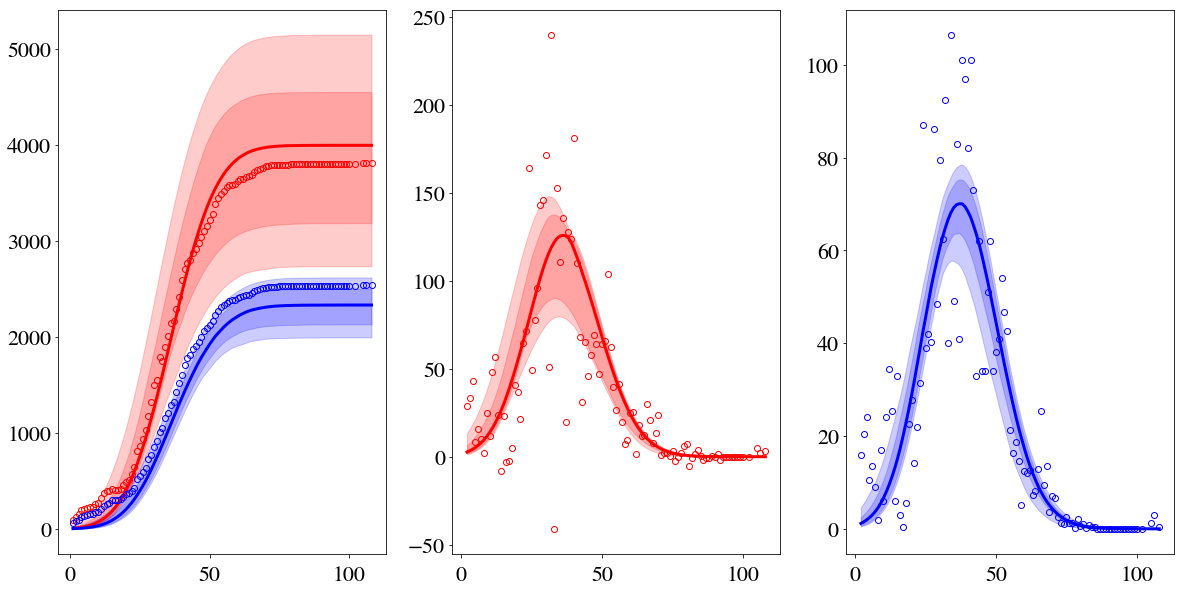

In [20]:
selection = np.random.choice(len(samples), 1000, replace=False)
e.makeplot(samples=samples[selection])
#plt.gcf().axes[0].set_ylim(top=10000)

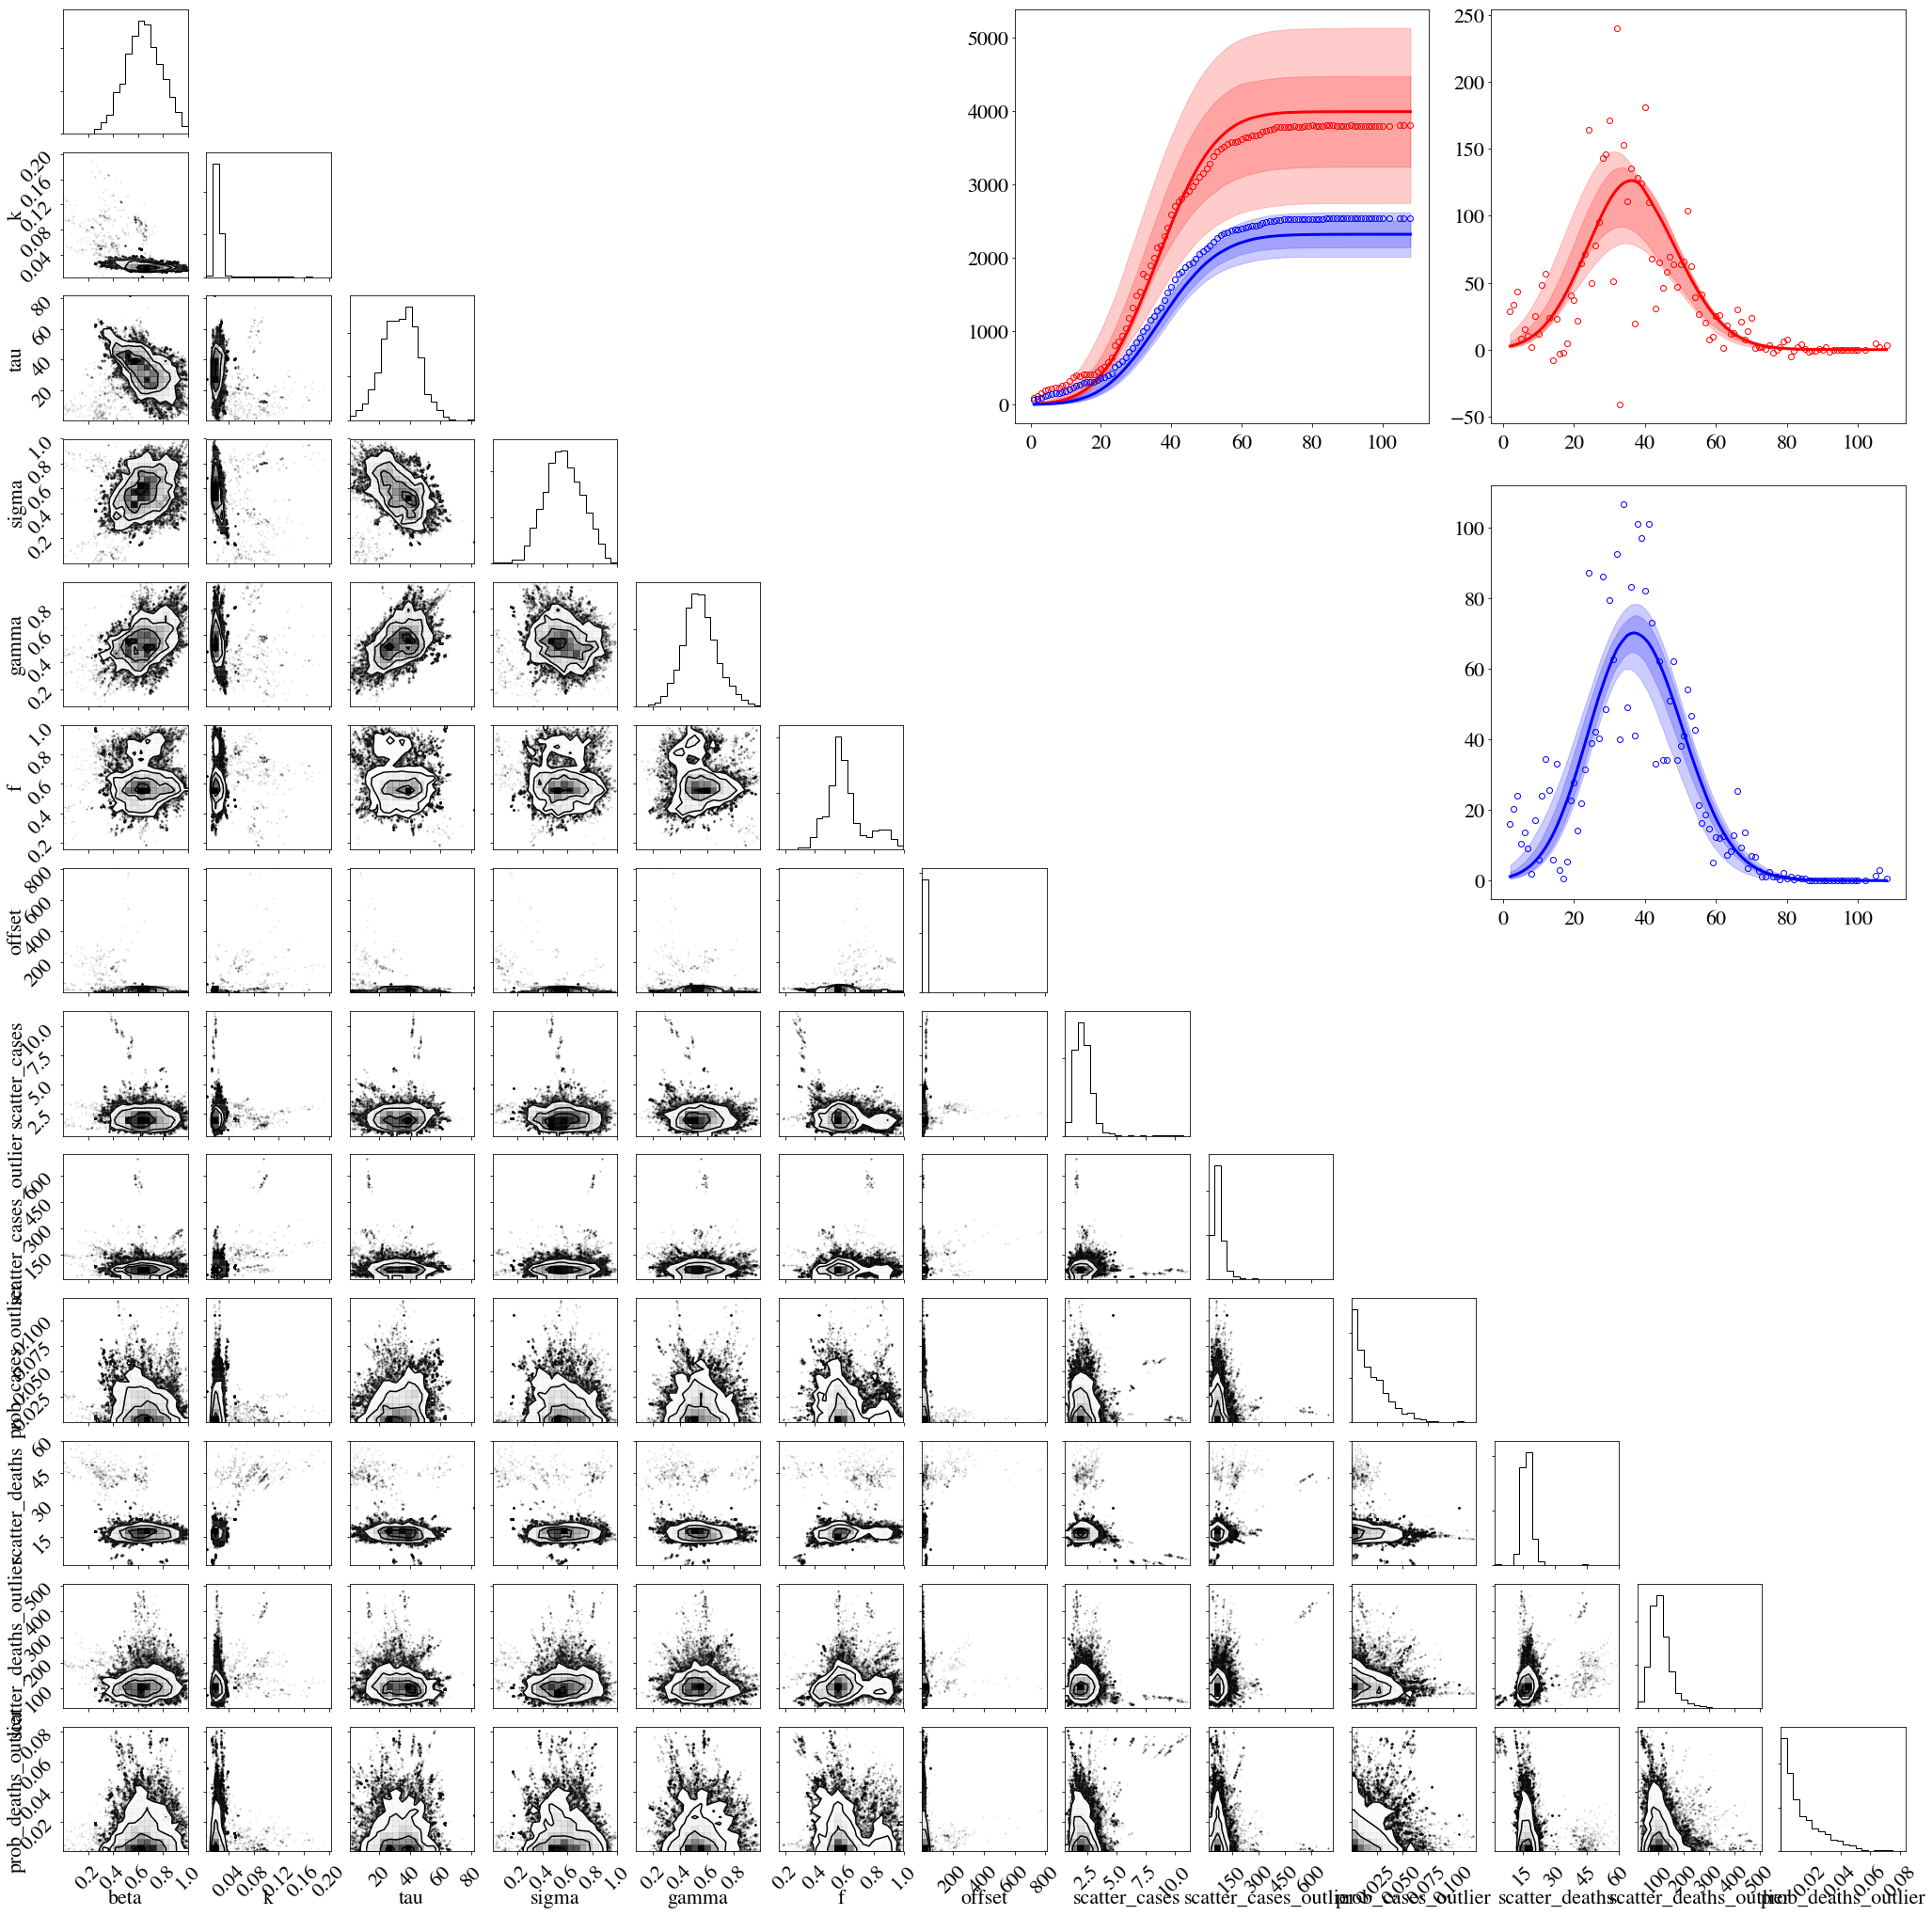

In [21]:
corner.corner(samples, labels=par)
ax0 = plt.subplot(4, 4, 3)
ax1 = plt.subplot(4, 4, 4)
ax2 = plt.subplot(4, 4, 8)
selection = np.random.choice(len(samples), 1000, replace=False)
e.makeplot(samples=samples[selection], ax=(ax0, ax1, ax2))
plt.subplots_adjust(wspace=0.15, hspace=0.15);

In [22]:
def round_sig(x, sig=1):
    d = sig-int(floor(log10(x)))-1
    d = max(0, d)
    return round(x, d), d


def summary(samples, truths=None):
    mean = samples.mean(0)
    sigma = samples.std(0)
    for i, p in enumerate(par):
        err, dp = round_sig(sigma[i], 1)
        val = round(mean[i], dp)
        dp = str(dp)
        dp += 'e}' if abs(log10(val)) > 3 else 'f}'
        outstr = ('{:16s} = {:8.'+dp+' ± {:<8.'+dp).format(p, val, err)
        if truths is not None:
            outstr += ('   ('+dp+')').format(truths[i])
        print(outstr)

In [23]:
summary(samples)

beta             =      0.6 ± 0.1     
k                =    0.023 ± 0.007   
tau              =       33 ± 12      
sigma            =      0.6 ± 0.1     
gamma            =      0.5 ± 0.1     
f                =      0.6 ± 0.1     
offset           =        7 ± 11      
scatter_cases    =      2.1 ± 0.8     
scatter_cases_outlier =       73 ± 33      
prob_cases_outlier =     0.02 ± 0.02    
scatter_deaths   =       17 ± 3       
scatter_deaths_outlier =      112 ± 46      
prob_deaths_outlier =     0.01 ± 0.01    
